# dl.ai NLP 1.2: sentiment analysis with naive Bayes
*deeplearning.ai NLP specialization (course)1.(week)2 notes by Samson Zhang*

The second week of course 1 is much shorter than the first, and goes over a much simpler method for sentiment analysis and other NLP binary classification tasks: naive Bayes.

## Naive Bayes

Remember this frequency chart from [1.1](https://www.kaggle.com/code/wwsalmon/dl-ai-nlp-1-1-sentiments-w-frequencies)?

*(All screenshots from the Coursera course)*

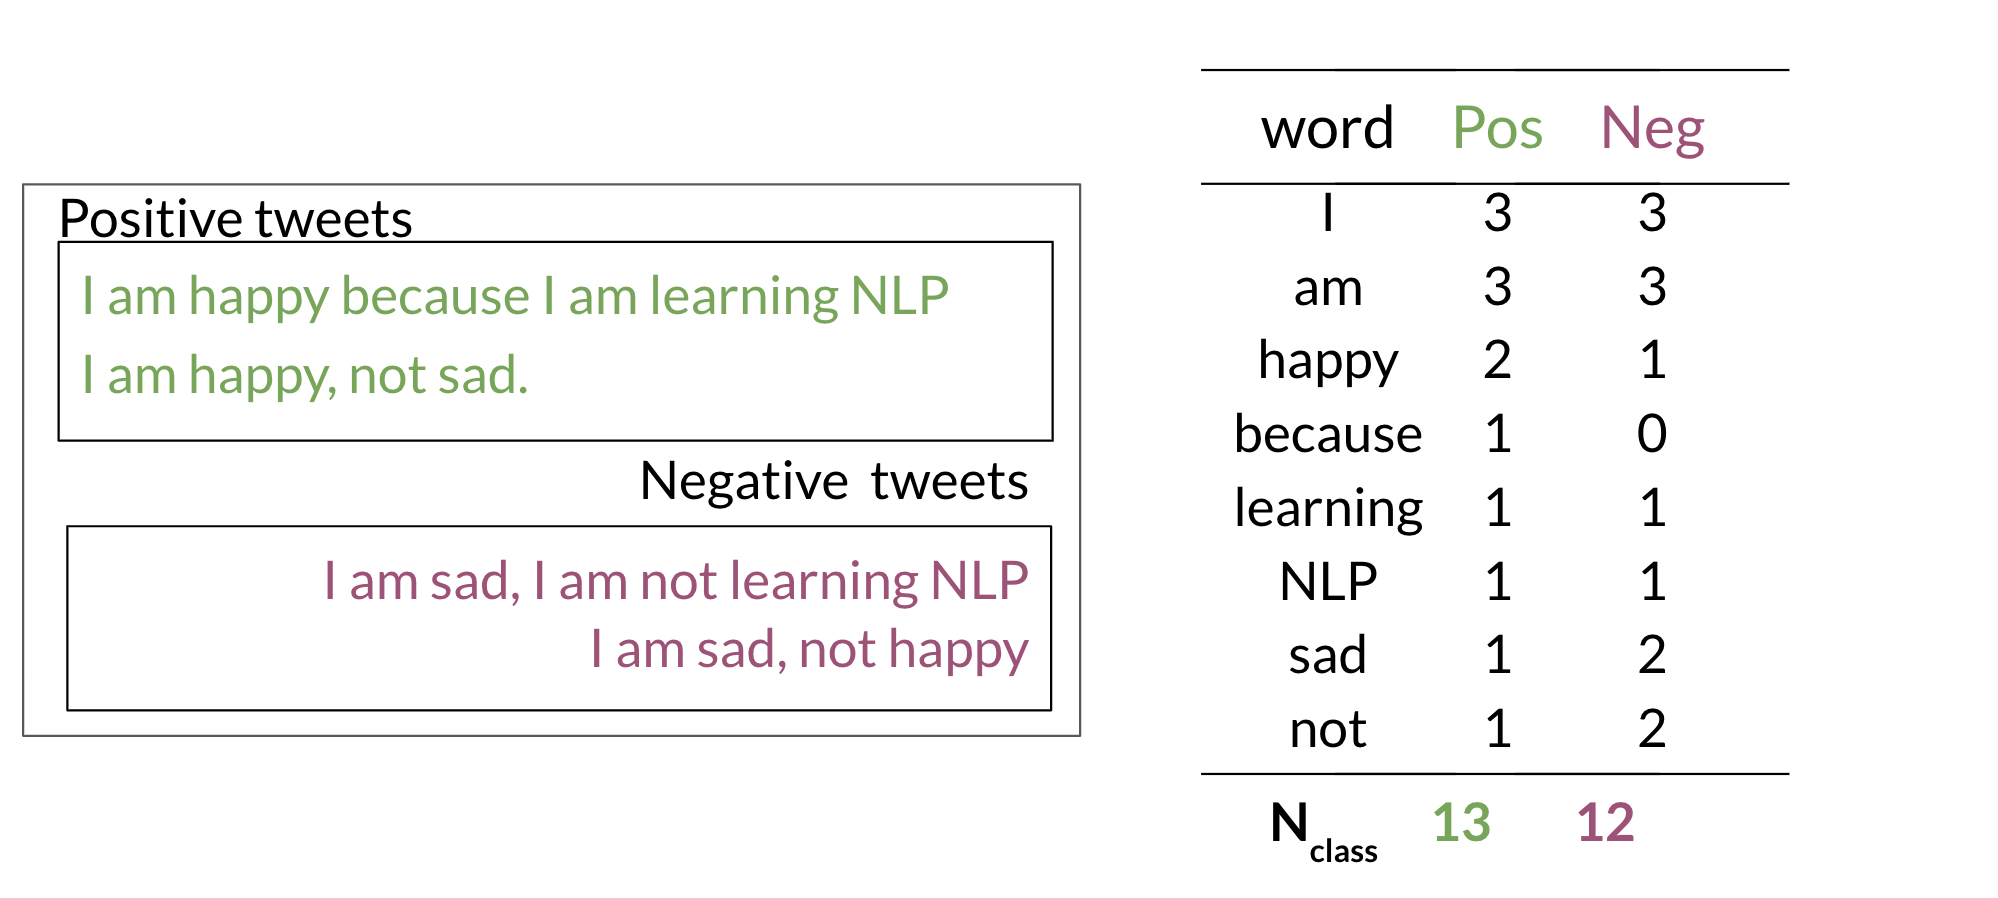

Let's divide each value by the sum of its column, so effectively each row gives $[w, P(w|\text{pos}), P(w|\text{neg})]$:

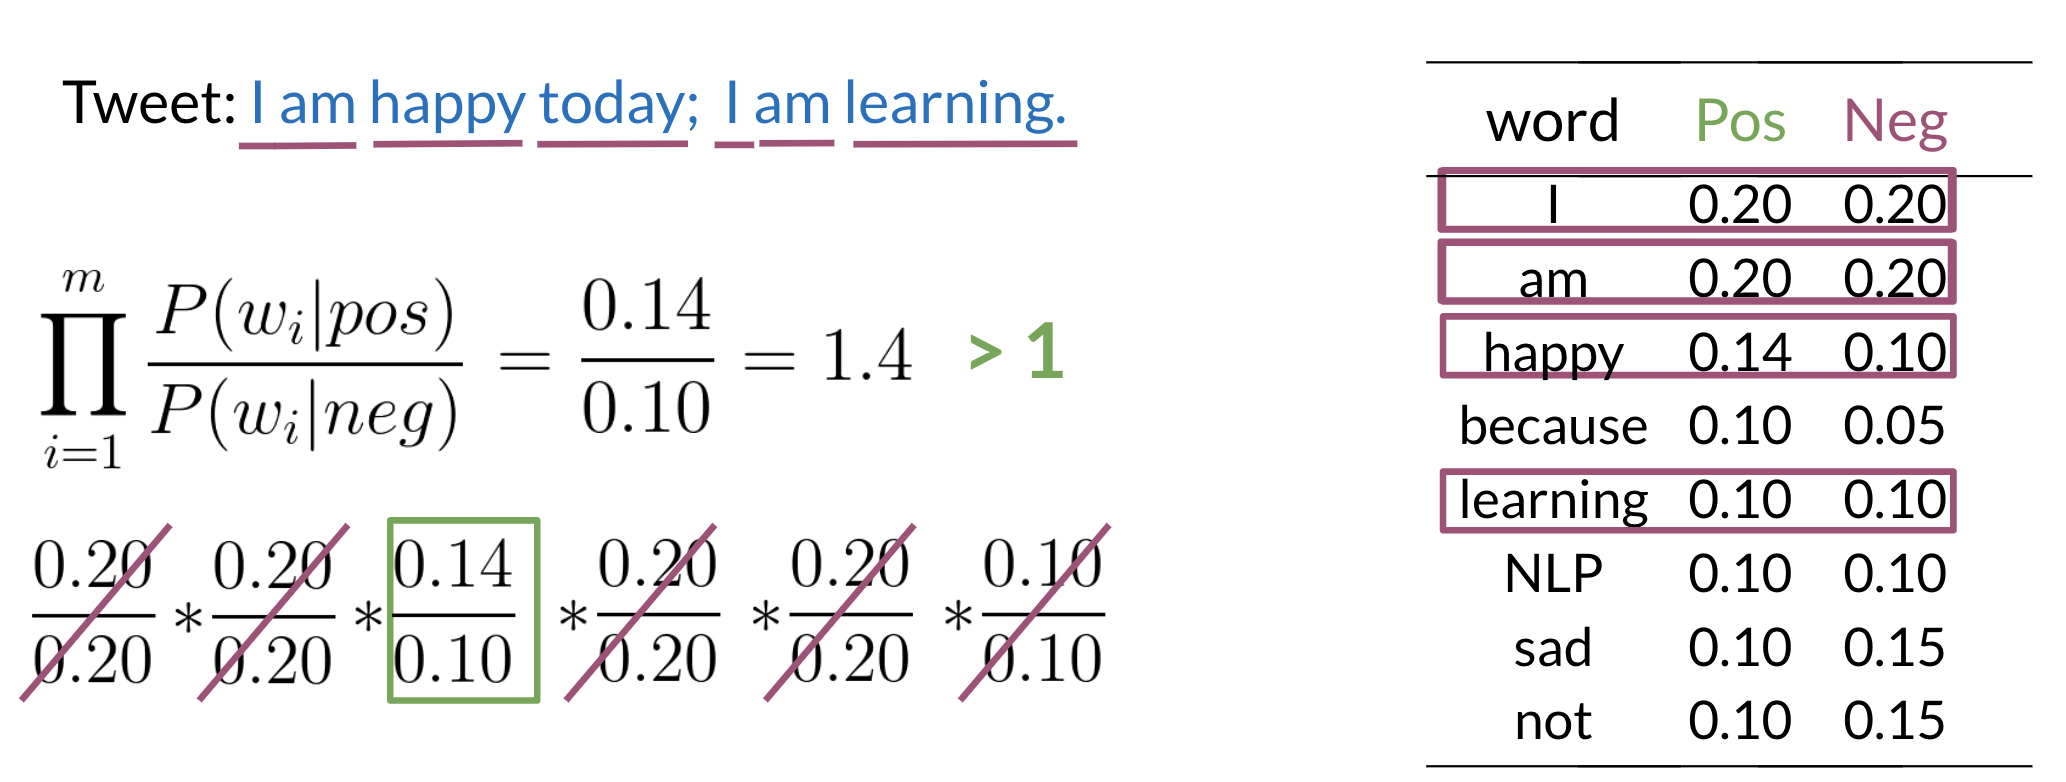

Then, as the above image also shows, we can infer if a sentence has a positive or negative sentiment simply by multiplying the probability ratios of the words using the formula and seeing if the product is greater than one:

$$\text{inference} = {\displaystyle \prod_{i=1}^{m} \frac{P(w_i|\text{pos})}{P(w_i|\text{neg})}} > 1$$

This formula assumes that $P(\text{pos}) = P(\text{neg})$. If this is not the case, as in most likely any real dataset, we need to add a **prior** factor (exposing where the classic $P(A|B) = P(B|A) \frac{P(A)}{P(B)}$ Bayes' formula comes in):

$$\text{inference} = {\displaystyle \frac{P(\text{pos})}{P(\text{neg})} \prod_{i=1}^{m} \frac{P(w_i|\text{pos})}{P(w_i|\text{neg})}} > 1$$

Note that if a word doesn't occur at all in either the negative or positive corpus examples, then the probability ratio for that word will be either $0$ or $\infty$ and break our inference.

To fix this problem, instead of using a straight up probability comparison we can do something called **Laplacian smoothing** to prevent this:

$$P_{\text{smooth}}(w|\text{class}) = \frac{\text{freq}(w,\text{class}) + 1}{N_\text{class}+V}$$

where $N_\text{class}$ is the sum of the frequency of each word in the class and $V$ is the number of unique words in the vocabulary.

## Log likelihood

One last improvement to this model is to take the log of the result to make it easier to calculate and interpret.

In its current form, the inference function returns a value between $0$ and $+\infty$, with $1$ being neutral. If we take the log of this function, we instead get a range from $-\infty$ to $+\infty$ with $0$ being neutral, which is much easier to interpret.

The property $\log(ab) = \log(a) + \log(b)$ also allows us to express our inference function as a sum instead of a product, preventing underflow errors from values getting too close to $0$ in the product of probability ratios calculation, that is:

$$
\begin{align*}
    \text{inference} &= \log\bigg({\displaystyle \frac{P(\text{pos})}{P(\text{neg})} \prod_{i=1}^m \frac{P(w_i|\text{pos})}{P(w_i|\text{neg})}}\bigg) > 1 \\
    &= \log\bigg(\frac{P(\text{pos})}{P(\text{neg})}\bigg) + \sum_{i=1}^m \log\frac{P(w_i|\text{pos})}{P(w_i|\text{neg})} > 1
\end{align*}
$$

To do this calculation efficiently, we can encode the value of $\log\frac{P(w|\text{pos})}{P(w|\text{neg})}$ as $\lambda(w)$ for every word in our corpus beforehand:

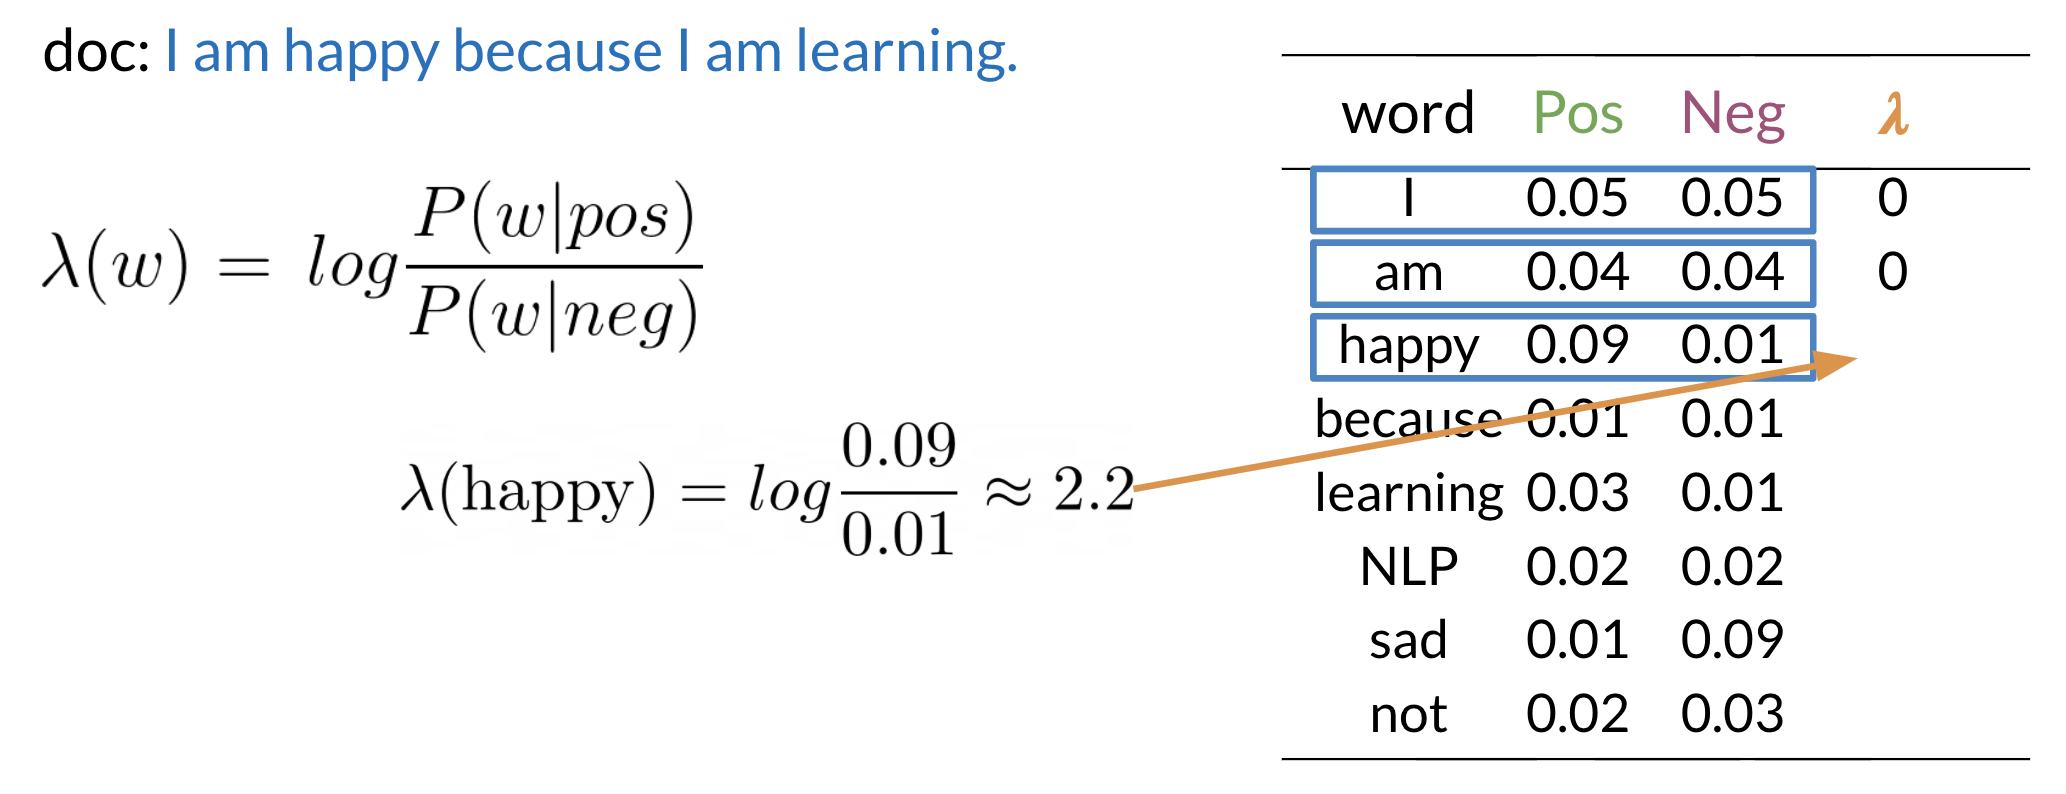

Then our inference equation becomes:

$$\text{inference} = \log\bigg(\frac{P(\text{pos})}{P(\text{neg})}\bigg) + \sum_{i=1}^m \lambda(w_i)$$

## Applications and limitations of naive Bayes

When is naive Bayes useful? For many simple binary classification tests, the Coursera course suggests:
- sentiment analysis
- classify a book as being written by one of two authors
- classify emails as spam or not
- guess between two meanings of a word in a given sentence

Being such a simple model, a naive Bayes classifier is much **faster to implement** (simple array/dict sums instead of intensive learning algs) and in many cases **more robust** than learning models like the linear regression one we made in [1.1](https://www.kaggle.com/code/wwsalmon/dl-ai-nlp-1-1-sentiments-w-frequencies).

However, the model is *naive* for a reason: it assumes that a word's effect on a sentence's classification is independent of the other words in the sentence, or the word order, or any other information not considered in the model; and it can be thrown off if the overall corpus does not have a good balance of data between and within its classes.

## Code implementation

Enough talking -- let's actually implement a naive Bayes sentiment classifier, **without looking at the course's code** (because it should be *that* simple), and see how it does!

First, splitting the data and taking the pre-processing code from [1.1](https://www.kaggle.com/code/wwsalmon/dl-ai-nlp-1-1-sentiments-w-frequencies):

In [1]:
import nltk
from nltk.corpus import twitter_samples

nltk.download('twitter_samples')
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [2]:
import string
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
stemmer = PorterStemmer()
stopwords_english = stopwords.words('english')    

def process_tweet(tweet):
    tweet_clean = re.sub(r'^RT[\s]+', '', tweet)
    tweet_clean = re.sub(r'https?://[^\s\n\r]+', '', tweet_clean)
    tweet_clean = re.sub(r'#', '', tweet_clean)
    tweet_clean = tweet_clean.lower()
    tweet_tokens = tokenizer.tokenize(tweet_clean)
    tweet_tokens = [token for token in tweet_tokens if (token not in stopwords_english and token not in string.punctuation)]
    tweet_tokens = [stemmer.stem(token) for token in tweet_tokens]
    return tweet_tokens

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now here's a function that creates a dictionary of lambda values:

In [3]:
import math

def get_lambda_dict(labeled_tweets):
    freqs = {}
    words = []
    n_pos = 0
    n_neg = 0
    for sentiment, tweet in labeled_tweets:
        for word in process_tweet(tweet):
            freqs[(word, sentiment)] = freqs.get((word, sentiment), 0) + 1
            words.append(word)
            if (sentiment == 1): n_pos+=1
            else: n_neg+=1
            
    lambdas = {}
    words = list(set(words))
    v = len(words)
    for word in words:
        p_pos = (freqs.get((word, 1), 0) + 1) / (n_pos + v)
        p_neg = (freqs.get((word, 0), 0) + 1) / (n_neg + v)
        lambdas[word] = math.log(p_pos / p_neg)

    return lambdas
    
labeled_tweets = [(1, tweet) for tweet in all_positive_tweets] + [(0, tweet) for tweet in all_negative_tweets]
lambdas = get_lambda_dict(labeled_tweets)

And finally, the inference function:

In [4]:
def inference(tweet):
    tweet_processed = process_tweet(tweet)
    tweet_score = 0
    for word in tweet_processed: tweet_score += lambdas.get(word, 0) # 0 if word not in dict
    return tweet_score

Let's test the model's accuracy across the entire corpus:

In [5]:
num_correct = 0
num_total = len(labeled_tweets)

for sentiment, tweet in labeled_tweets:
    prediction = int(inference(tweet) > 0)
    if prediction == sentiment: num_correct += 1

accuracy = num_correct / num_total
print(accuracy)

0.999


As expected, on the very corpus on which the model was trained, it performs very well. Even here it isn't perfect, as we are greatly reducing the amount of information the model considers.

Now let's do a loose test of its generalizability by giving it a tweet of mine:

In [6]:
my_tweet = "happy to share that @XuehuaiH, Saatvik Kher & I won runner-up for Best Insight among 70+ teams at @UCLADataFest this weekend! thanks to prof @jo_hardin47 for bringing us + for the pics :D"
print(inference(my_tweet))

20.15506717124949


And a few negative ones:

In [7]:
# https://twitter.com/AndrewDesiderio/status/1526640785235529728
my_tweet = "NEW: Ukraine aid splinters GOP. With the nationalist camp growing larger and louder, most Hill Republicans — from rank & file up to McConnell — are aggressively pushing back on what they see as a disturbing trend toward isolationism."
print(inference(my_tweet))

0.8678000537777799


In [8]:
# https://twitter.com/ErieNotEerie/status/1526481437754642433
my_tweet = "How does someone like Mitch McConnell keep getting elected, with his abysmal approval rating?"
print(inference(my_tweet))

1.2992208786414894


In [9]:
# https://twitter.com/393279634eab410/status/1526647059440336898
my_tweet = "Because he made a promise to himself, she's like poison ivy to him and doesn't want to get tangled up in her web of lies again. I understand what he he's going through. My ex wanted to have dinner with me and the kids, I turned him down, didn't want to give any false hopes."
print(inference(my_tweet))

-1.7218029545979627


All three have *lower* scores than the positive tweet, but only 1/3 is actually predicted corectly.